# Showcase of the new LNHR DAC II QCoDeS driver (v0.2.0)

Copyright (c) Basel Precision Instruments GmbH (2025), written for the QCoDeS driver `Baspi_Lnhrdac2.py`, v0.2.0

...........................................................................................................................................................................................................................................

This notebook shows brief examples on the changes made and on how to use the new and improved QCoDeS driver for the Basel Precision Instruments LNHRDAC II.

## 1 - Imports and setting up a Station

What's new? Generally names have been changed to previous versions of the driver to fall in line with the QCoDeS recommendations. The behaviour of the DAC upon device creation has also changed. The DAC tells the user what it does after Startup.

The main driver class is the `BaspiLnhrdac2` class. For simple use cases as applying DC-voltages, this is the only class needed. If advanced functions of the DAC such as the Arbitrary Waveform Generator (AWG) or the fast adaptive 2D scan are used, the classes `BaspiLnhrdac2SWGConfig` and `BaspiLnhrdac2Fast2dConfig` are also needed.

In [1]:
from qcodes.station import Station
from Baspi_Lnhrdac2 import BaspiLnhrdac2, BaspiLnhrdac2SWGConfig, BaspiLnhrdac2Fast2dConfig

In [4]:
station = Station()
DAC = BaspiLnhrdac2('LNHRDAC', 'TCPIP0::192.168.0.5::23::SOCKET')
station.add_component(DAC)


Connected to: Basel Precision Instruments GmbH (BASPI) LNHR DAC II (SP1060) - 24 channel version (serial:SN 10600000011, firmware:Revision 3.4.9u) in 6.45s
All channels have been turned off (1 MOhm Pull-Down to AGND) upon initialization and are pre-set to 0.0 V if turned on without setting a voltage beforehand.



'LNHRDAC'

## 2 - Using the DAC as a DC Voltage source

What's new? Everything is using easy to understand parameters now.

Using the DAC as a computer controlled DC voltage source, every channel of the DAC can be controlled through three main parameters.
- `chN.voltage`: Sets or gets the voltage currently applied to the output. Default is 0.0 V.
- `chN.high_bandwidth`: Sets or gets if the high bandwidth mode (100 kHz) is activated or not. Default is high bandwidth deactivated, meaning the channel is in low bandwidth mode (100 Hz), for best noise performance.
- `chN.enable`: Enables or disables the output. If a DAC channel is disabled, no voltage is outputted (output open, 1 MOhm to AGND).

The `chN.high_bandwidth.set()` and `chN.enable.set()` can not only be controlled with the arguments `"on"` and `"off"` but with `True` and `False` too.

Using the more advanced functions of the DAC such as the AWG, the `chN.high_bandwidth` and `chN.enable` are still used to control the bandwidth and enabling or disabling the outputs.

In [5]:
DAC.ch14.voltage.set(5.86)
DAC.ch14.high_bandwidth.set("off")
DAC.ch14.enable.set(True)

voltage = DAC.ch14.voltage.get()
print(f"{voltage} V")

5.86 V


In [6]:
DAC.all.voltage.set(-1.248)
DAC.all.enable.set(True)
voltages = DAC.all.voltage.get()
print(voltages)

(-1.248, -1.248, -1.248, -1.248, -1.248, -1.248, -1.248, -1.248, -1.248, -1.248, -1.248, -1.248, -1.248, -1.248, -1.248, -1.248, -1.248, -1.248, -1.248, -1.248, -1.248, -1.248, -1.248, -1.248)


## 3 - Using the DAC as an Arbitrary Waveform Generator (AWG)

What's new? Again, everything is using easy to understand parameters now. Everything shown in this chapter, could have been done with the older drivers, but it was a very tedious and much more complex process and the documentation was not easily available. With the new parameters, everything has been drastically simplified.

Broadly speaking, the process of using the AWG can be divided into to steps:
- Generating and saving a waveform to the device memory 
- Outputting it on the device

The 12 channel version of the LNHR DAC II has two AWGs, AWG A and AWG B, whereas the 24 channel version has four AWGs, AWG A, AWG B, AWG C and AWG D. All AWGs have their own set of parameters.

There are two ways on how a waveform can be generated and saved to device memory.

### 3.1 - Creating a waveform using the integrated Standard Waveform Generator (SWG)

The integrated Standard Waveform Generator (SWG) instrument module aids with the generation of simple signals, such as:
- sine and cosine
- triangualar and sawtooth signals
- rectangular and pulse/ PWM signals
- fixed and random white noise

To configure the SWG, an object of class `BaspiLnhrdac2SWGConfig` must be passed to the `swg.configuration`parameter. Once parametrized, the waveform can be saved to the device memory using the `swg.apply` method.

In [7]:
config = BaspiLnhrdac2SWGConfig(
    shape = "sawtooth",
    frequency = 80.0,
    amplitude = 1.03,
    offset = 0.0,
    phase = 0.0
)

DAC.swg.configuration.set(config)
DAC.swg.apply("A")

### 3.2 - Creating a waveform using a set of custom data

For more complex waveforms, a fully custom waveform can be directly written to device memory, using the `awgX.waveform` parameter. Before the waveform is set, the `awgX.length` parameter has to be updated. Additionally there is the option to set the `awgX.sampling_rate` parameter. It is important to note, that the AWG A and AWG B share the same sampling rate, as do AWG C and AWG D. Therefore, by changing the `awga.sampling_rate` the `awgb.sampling_rate` is changed too.

Writing a waveform directly to the device memory comes with the advantage of full customizability, however, especially relevant for larger waveforms (more points), this method is slower than using the SWG.

In [8]:
from numpy import empty, sin
from random import random

# creating a noisy rectangular signal
waveform = empty(100)
for i in range(0, len(waveform)):
    sign = 1 if bool(round(random())) else -1
    amplitude = 8 if sin(i/10) >= 0 else -8
    waveform[i] = round(amplitude + ((random()) * sign), 6)

In [9]:
DAC.awgb.length.set(len(waveform))
DAC.awgb.sampling_rate.set(0.1)
DAC.awgb.waveform.set(waveform)

### 3.3 - Output the saved waveform

Once the waveform is saved to the device memory, the AWG can be set up to output the waveform.

If an external trigger is desireable, the `awgX.trigger` parameter provides the following possibilities:
- `"disable"`: no external trigger, AWG started by software
- `"start only"`: rising edge on the AWGs trigger input starts the AWG
- `"start stop"`: rising edge on the AWGs trigger input starts the AWG, falling edge stops it, indefinetly repeatable
- `"single step"`: on each rising edge on the AWGs trigger input, the AWG outputs the next stored value from memory, this results in the irrelevance of the `awgX.sampling_rate` parameter

It should also be noted, that the `chN.enable` and `chN.high_bandwidth` parameters still control the channels.

In [10]:
DAC.ch3.enable.set("on")
DAC.ch3.high_bandwidth.set("on")

DAC.awga.channel.set(3)
DAC.awga.cycles.set(615)
DAC.awga.trigger.set("disable")
DAC.awga.enable.set("on")


DAC.ch8.enable.set("on")
DAC.ch8.high_bandwidth.set("on")

DAC.awgb.channel.set(8)
DAC.awgb.cycles.set(0) # infinite repetitions
DAC.awgb.trigger.set("disable")
DAC.awgb.enable.set("on")

### 3.4 - Read and plot the saved waveform

Once saved to device memory, the user can read the waveforms through the `awgX.waveform` parameter. This is a parameter with setpoints, the setpoints are stored inside the parameter `awgX.time_axis`. Therefore the user automatically gains access to the time intervals of the waveform, which allows for an easy way to plot it.

In [11]:
awga = DAC.awga.waveform.get()
awga_setpoints = DAC.awga.time_axis.get()

print(f"Values stored in AWG A device memory ({DAC.awga.length.get()} datapoints, in V):")
print(f"{awga}\n")

print(f"Time intervals for AWG A ({DAC.awga.length.get()} datapoints, in s):")
print(f"{awga_setpoints}\n")

Values stored in AWG A device memory (1250 datapoints, in V):
[ 0.        0.001648  0.003296 ... -0.004944 -0.003296 -0.001648]

Time intervals for AWG A (1250 datapoints, in s):
[0.000e+00 1.000e-01 2.000e-01 ... 1.247e+02 1.248e+02 1.249e+02]



The following code is paraphrased from the QCoDeS documentation website, showing how to plot a parameter with setpoints. Plotting this data can of course also be done in other ways.

Starting experimental run with id: 105. 


([<Axes: title={'center': 'Run #105, Experiment BASPI LNHR DAC demo (example scans)'}, xlabel='time (s)', ylabel='waveform AWG A (V)'>],
 [None])

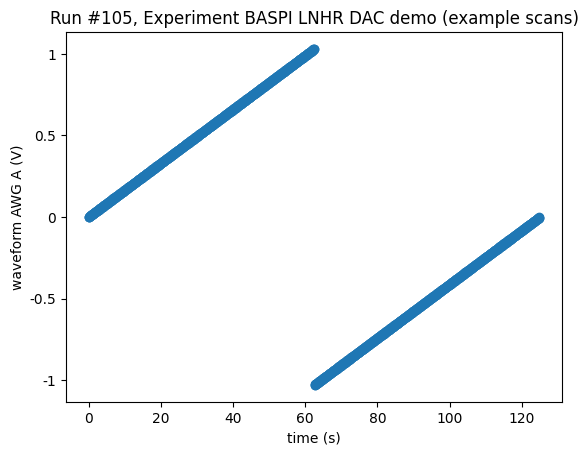

In [12]:
from qcodes.dataset import Measurement, plot_dataset

# set measurement contex
measurement = Measurement()
measurement.register_parameter(DAC.awga.time_axis)
measurement.register_parameter(DAC.awga.waveform, setpoints = (DAC.awga.time_axis,))

# get data from device and save as plottable data
with measurement.run() as datasaver:
    datasaver.add_result((DAC.awga.time_axis, DAC.awga.time_axis.get()), (DAC.awga.waveform, DAC.awga.waveform.get()))
    dataset = datasaver.dataset

plot_dataset(dataset)

## 4 - Using the DAC for 2D-scans

What's new? Similar to the AWG and SWG submodules, this driver introduces a fast adaptive 2D scan submodule with easy to understand parameters.

But what if a 2D-scan is not time critical? The old fashioned way of using the QCoDeS `do2d` method still works. To decide which method should be used, the following might help decide:
- `do2d`
    - works with most QCoDeS compatible voltage sources
    - is easy to use; coordination between source and measurement device is automatically done by QCoDeS
    - speed of the 2D-scan is restricted by communication speed of the used devices and computing power of the QCoDeS running device, therefore scans are usually slow

- `fast2d`
    - only works with the LNHRDAC II
    - is easy to set up; the scan is configured through the `BaspiLnhrdac2Fast2dConfig` class and the trigger parameter
    - speeds of down to 10 &mu;s per point are possible, independent of computing power and communication speeds
    - different external trigger modes are available

### 4.1 - Using the standard QCoDeS `do2d`

As with all past QCoDeS drivers for the LNHRDAC II, the `do2d` method still creates a simple 2D-scan. 

The example below uses a dummy instrument for the data acquisition, such that QCoDeS has some data to plot. This must obviously eventually be replaced with a real instrument.

Starting experimental run with id: 106. Using 'qcodes.dataset.do2d'


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

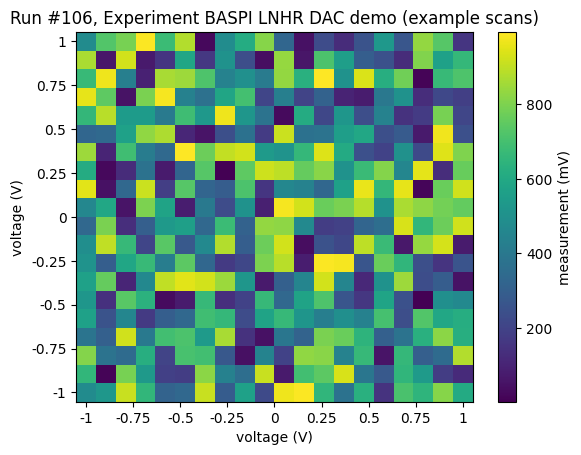

In [13]:
from qcodes.instrument import Instrument, Parameter
from qcodes.utils.dataset.doNd import do2d
import random

# random measurement parameter mimicking a real measurement device
class RandomNumberParameter(Parameter):
    def get_raw(self):
        return random.random()

class RandomNumberInstrument(Instrument):
    def __init__(self, name):
        super().__init__(name)
        self.add_parameter('measurement', parameter_class=RandomNumberParameter, unit='V')

    def get_idn(self):
        return {"vendor": "BasPI", "model": str(self.__class__), "serial": "NA", "firmware": "NA"}

# instantiate the dummy measurement instrument
dummy_instrument = RandomNumberInstrument('random_measurement_instrument')

# select specific channels 
V1 = DAC.ch1.voltage # voltage output channel 1
V2 = DAC.ch2.voltage  # voltage output channel 2

# perform a 2D measurement using the standard QCodDes do2d function
result, _, _ = do2d(
    V1, -1, 1, 20, 0.01,
    V2, -1, 1, 20, 0.01,
    dummy_instrument.measurement,
    do_plot=True,
    show_progress=True
)

### 4.2 - Using the LNHR DAC II specific fast adaptive 2D scan `fast2d`

For a faster adaptive 2D-scan the `fast2d` method of the LNHRDAC II can be used. In a first step, the parameters of the 2D-scan must be defined, in a second step the trigger and DAC outputs must be configured. 

To configure the 2D-scan parameters, an object of class `BaspiLnhrdac2Fast2dConfig` must be created and forwarded to the `fast2d.configuration.set()` parameter. The driver will then automatically configure the DAC correctly in the background. This may take a few seconds.

In [17]:
config = BaspiLnhrdac2Fast2dConfig(
        x_channel = 3,
        x_start_voltage = 0.0,
        x_stop_voltage = 0.5,
        x_steps = 10,
        y_channel = 7,
        y_start_voltage = 0.0,
        y_stop_voltage = 0.5,
        y_steps = 5,
        acquisition_delay = 0.013,
        adaptive_shift = 0.0
)

DAC.fast2d.configuration.set(config)

Starting to configure fast adaptive 2D scan. AWG A will be repurposed. AWG A and AWG B connot be used while the 2D scan is running.
Fast adaptive 2D scan sucessfully configured. Ready to start.


After setting the configuration the `fast2d.trigger` parameter can be configured. The LNHRDAC II supports four trigger modes:
- `disable`: no trigger is selected, the scan goes as fast as possible, started via software
- `line in`: the LNHRDAC II receives a trigger signal, starting each y-axis (fast axis) sweep, whilst the x-axis (slow axis) sweep is done automatically
- `line out`: the LNHRDAC II sweeps both axes automatically and sends a trigger signal whith every start of a y-axis (fast axis) sweep
- `point out`: the LNHRDAC II sweeps both axes automatically and sends a trigger signal whith every point of the 2D-scan

Those trigger modes allow for various possible synchronisation methods inbetween the LNHRDAC II and the used data aqcusition system.

Finally the outputs must be configured correctly, using the `high_bandwidth`and `enable`parameters of the respective channels. Additionally, setting the output voltages of the chosen outputs to the starting voltage of the 2D-scan might be necessary as well.

In [19]:
from time import sleep

# enable and configure trigger
DAC.ch22.high_bandwidth.set(True)
DAC.ch22.voltage.set(0.0)
DAC.ch22.enable.set(True)
DAC.fast2d.trigger_channel.set(22)
DAC.fast2d.trigger.set("point out")

# enable x-axis
DAC.ch3.high_bandwidth.set(True)
DAC.ch3.voltage.set(config.x_start_voltage)
DAC.ch3.enable.set(True)

# enable y-axis
DAC.ch7.high_bandwidth.set(True)
DAC.ch7.voltage.set(config.y_start_voltage)
DAC.ch7.enable.set(True)

# start 2D-scan
DAC.fast2d.enable.set("on")

Starting to configure fast 2D scan trigger. AWG C might be repurposed. AWG C and AWG D connot be used while the point to point trigger output is running.
Trigger mode 'point out' requires a physical connection inbetween the devices 'Sync Out AWG A' and 'Trig In AWG C' outputs.
Fast 2D scan trigger now set to 'point out', using DAC channel 22.
Fast adaptive 2D scan started with configuration BaspiLnhrdac2Fast2dConfig(x_channel=3, x_start_voltage=0.0, x_stop_voltage=0.5, x_steps=10, y_channel=7, y_start_voltage=0.0, y_stop_voltage=0.5, y_steps=5, acquisition_delay=0.013, adaptive_shift=0.0).


The `fast2d` submodule has no implemented plotting funtion. The collected data from a 2D-scan must therefore be manually plotted by the user. The voltages outputted by the LNHRDAC II can be read out with the `fast2d.x_axis.get()` and `fast2d.y_axis.get()` parameters.

In [18]:
x_axis = DAC.fast2d.x_axis.get()
y_axis = DAC.fast2d.y_axis.get()

print(f"Y-axis values are:")
print(y_axis)
print(f"X-axis values are:")
print(x_axis)

Y-axis values are:
[0.  0.1 0.2 0.3 0.4 0.5]
X-axis values are:
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]
